In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import *
import os
import numpy as np


import os
import numpy as np

import cv2
import nibabel as nib


import gudhi
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from persim import plot_diagrams
from ripser import ripser, lower_star_img
from skimage.transform import resize
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression

In [2]:
import imageio
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np # linear algebra
import pandas as pd # reading and processing of tables
import skimage, os
from skimage.morphology import convex_hull_image
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage.util import montage as montage2d
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import dicom
import scipy.misc
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
CT_OFFSET = 1024
ZERO_VALUE = 0

In [3]:
def calculate_severity(i, j):
    mypath = 'data/{}/'.format(str(i))
    i_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'DS_Store' not in f]
    i_files = list(set([x.split('_')[1] for x in i_files]))
    j = i_files[j]
    datafiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
    mypath = 'results/{}/'.format(str(i))
    maskfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
    areas = []
    for datafile, maskfile in zip(datafiles, maskfiles):
        im = cv2.imread('data/{}/'.format(str(i)) + datafile, cv2.IMREAD_GRAYSCALE)
        im = im > 0
        higher = np.sum(im[260:, :])
        lower = np.sum(im[:260, :])
        if type(im) == type(None) or (higher+lower) < 0.125 * (im.shape[0] * im.shape[1]):
            continue
        msk = cv2.imread('results/{}/'.format(str(i)) + maskfile, cv2.IMREAD_GRAYSCALE)
        msk = msk > 0
        msk = np.multiply(msk, im)
        msk = binary_dilation(msk, disk(20, dtype=bool))
        areas.append(np.max((np.sum(msk[260:, :])/higher, np.sum(msk[:260, :])/lower)))
    if len(areas) < 2:
        return np.zeros(10)
    sorted_index_array = np.argsort(areas)
    areas_10 = np.array(areas)[sorted_index_array[-10:]]
    areas = np.zeros(10)
    areas[-len(areas_10):] = areas_10
    return areas

In [4]:
with open('squares/squares.npy', 'rb') as f:
    squares = np.load(f)
with open('squares/targets.npy', 'rb') as f:
    targets = np.load(f)

In [5]:
len(squares), len(targets)

(37782, 37782)

In [6]:
X = squares
y = targets
y_binary = np.array([t > 0 for t in y])
rus = RandomUnderSampler(random_state=42)
X_ind, y_ind = rus.fit_resample(np.arange(len(X)).reshape(-1, 1), y_binary)
X_train, X_test, y_train, y_test = train_test_split(X[X_ind.flatten()], y[[X_ind.flatten()]], shuffle=True)

<ipython-input-6-c2b1f68acdc3>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_train, X_test, y_train, y_test = train_test_split(X[X_ind.flatten()], y[[X_ind.flatten()]], shuffle=True)


In [7]:
def my_rescale(image_old, low_new=0.0, high_new=1.0):
    low_old = np.min(image_old)
    high_old = np.max(image_old)
    range_new = high_new - low_new
    range_old = high_old - low_old
    factor = range_new / range_old
    image_new = (image_old.astype(float) - low_old) * factor + low_new
    return image_new

In [8]:
# dice = np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))

# print 'Dice similarity score is {}'.format(dice)

In [9]:
from os import listdir
from os.path import isfile, join

diagrams_train = []
labels_train = []
diagrams_test = []
labels_test = []

images = []
for i in tqdm(np.arange(len(X_train))):
    diagrams_train.append(lower_star_img(X_train[i]/255.0))
    labels_train.append(y_train[i])
for i in tqdm(np.arange(len(X_test))):
    diagrams_test.append(lower_star_img(X_test[i]/255.0))
    labels_test.append(y_test[i])

100%|██████████| 2181/2181 [00:05<00:00, 407.81it/s]


In [10]:
def plot_img_and_dgm_ripser(img, name=''):
    dgm = lower_star_img(img)
    print('Image shape', img.shape)
    print('Diagram shape', dgm.shape)
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(img)
    plt.colorbar()
    plt.title('Image {}'.format(name))
    plt.subplot(122)
    plot_diagrams(dgm)
    plt.title('0-D persistence diagrams')
    plt.tight_layout()
    plt.show()
    return None



In [11]:
len(y_train)

6543

In [12]:
np.argwhere(targets > 0.25)

array([[   49],
       [   70],
       [   76],
       ...,
       [36858],
       [36917],
       [37656]])

In [13]:
targets[np.argwhere(targets > 0.25)]

array([[0.3359375 ],
       [0.4921875 ],
       [0.79785156],
       ...,
       [0.25683594],
       [0.35253906],
       [0.36425781]])

Image shape (32, 32)
Diagram shape (42, 2)


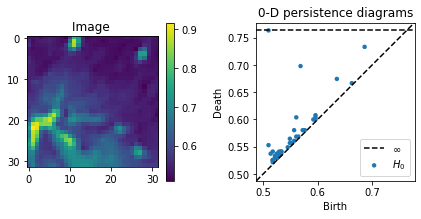

In [14]:
plot_img_and_dgm_ripser(squares[70]/255.0)

Image shape (32, 32)
Diagram shape (44, 2)


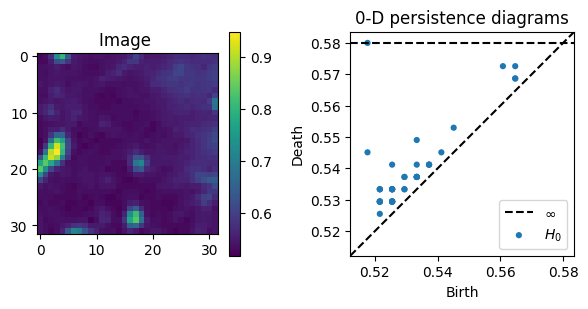

In [15]:
plot_img_and_dgm_ripser(squares[75]/255.0)

## 1. Gudhi representations

In [16]:
%%time
import gudhi.representations as tda
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm

CPU times: user 4.8 ms, sys: 4.35 ms, total: 9.14 ms
Wall time: 15.8 ms


In [17]:
for i in tqdm(range(len(diagrams_train))):
    array = diagrams_train[i]
    whereinf = np.isfinite(array)
    array[~whereinf] = 1
    array = np.nan_to_num(array)
    diagrams_train[i] = array

for i in tqdm(range(len(diagrams_test))):
    array = diagrams_test[i]
    whereinf = np.isfinite(array)
    array[~whereinf] = 1
    array = np.nan_to_num(array)
    diagrams_test[i] = array

100%|██████████| 2181/2181 [00:00<00:00, 35170.10it/s]


In [18]:
from lightgbm import LGBMRegressor as lgb

In [19]:
y_test

array([0.22167969, 0.06933594, 0.        , ..., 0.        , 0.16796875,
       0.        ])

In [20]:
import gudhi.representations as tda
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
pipe = Pipeline([("TDA",       tda.BettiCurve()),
                 ("Estimator", lgb(max_depth=2))])

param =    [{"TDA": [tda.BettiCurve()], 
             "TDA__resolution": [300],
             "Estimator": [lgb(max_depth=1), lgb(max_depth=2), lgb(max_depth=3)]},
           ]
model = GridSearchCV(pipe, param, cv=3)
grid = ParameterGrid(model.param_grid)

In [21]:
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix

In [22]:
len(diagrams_test)

2181

In [23]:
%matplotlib inline
pipes = []
counter = 0

for g in grid:
    t_0 = time.time()
    tdd = g['TDA']
    g['TDA'] = tdd
    estimator = g['Estimator']
    g['Estimator'] = estimator
    for k in g.keys():
        if '__' in k:
            setattr(g[k.split('__')[0]], k.split('__')[1], g[k])
    pipe = Pipeline([("TDA", g['TDA']), ("Estimator", g['Estimator'])])
    pipe.fit(diagrams_train, labels_train)
    print('PIPE NUMBER ', counter)
    print('PIPE: ')
    print(pipe)
    counter += 1
    test_score = pipe.score(diagrams_test, labels_test)
    train_score = pipe.score(diagrams_train, labels_train)
    print("TEST SCORE", test_score)
    print("TRAIN SCORE", train_score)
    print("OVERFIT SCORE", train_score/test_score)
    print("TIME PASSED", time.time() - t_0, "sec")
    print()
    print()
#     cm = confusion_matrix(labels_test, pipe.predict(diagrams_test))
#     sns.heatmap(cm, annot=True,fmt='g')
#     plt.show()
    pipe = Pipeline([("TDA", g['TDA']), ("Estimator", g['Estimator'])])
    pipes.append(pipe)

PIPE NUMBER  0
PIPE: 
Pipeline(steps=[('TDA',
                 BettiCurve(resolution=300, sample_range=array([0., 1.]))),
                ('Estimator', LGBMRegressor(max_depth=1))])
TEST SCORE 0.43264743069119915
TRAIN SCORE 0.4820989588472281
OVERFIT SCORE 1.1142998308738943
TIME PASSED 2.0244851112365723 sec


PIPE NUMBER  1
PIPE: 
Pipeline(steps=[('TDA',
                 BettiCurve(resolution=300, sample_range=array([0., 1.]))),
                ('Estimator', LGBMRegressor(max_depth=2))])
TEST SCORE 0.49727301625188747
TRAIN SCORE 0.595830863993235
OVERFIT SCORE 1.1981966535892314
TIME PASSED 1.908224105834961 sec


PIPE NUMBER  2
PIPE: 
Pipeline(steps=[('TDA',
                 BettiCurve(resolution=300, sample_range=array([0., 1.]))),
                ('Estimator', LGBMRegressor(max_depth=3))])
TEST SCORE 0.5171415357957043
TRAIN SCORE 0.6479774454223085
OVERFIT SCORE 1.2529982617336903
TIME PASSED 1.9700307846069336 sec




In [24]:
pipe = pipes[-1]

## TEST DICE

In [25]:
len(X_test)

2181

In [26]:
y_test

array([0.22167969, 0.06933594, 0.        , ..., 0.        , 0.16796875,
       0.        ])

In [28]:
pipe = pipes[-1]
pipe.fit(diagrams_train, labels_train)
list(pipe.predict(diagrams_test))

[0.12542526610204346,
 0.024651888182853837,
 0.044186566916633176,
 0.025404435894617272,
 0.020395484131453118,
 0.05194211652462502,
 0.008081830049238709,
 0.11016423288047379,
 0.02173862818732983,
 0.03341231718089293,
 0.0163818570890831,
 0.01730183279889476,
 0.09964518066826773,
 0.03694782633475176,
 0.02431432742679223,
 0.027324541291298396,
 0.2715016617597787,
 0.05157214234174575,
 0.14428039995992056,
 0.12083836065285723,
 0.06860649453689746,
 0.2763222621529565,
 0.24701871079384063,
 0.03990850495864169,
 0.14878397321308687,
 0.065986458680929,
 0.06684343241001134,
 0.1404826792214881,
 0.1384748542291124,
 0.04411996515746772,
 0.06058161569358316,
 0.062186305797339504,
 0.01144884941004523,
 0.06490807864917286,
 0.04144839514096167,
 0.1330836139157944,
 0.30220651538498394,
 0.009323352078178812,
 0.029940455657657676,
 0.020371154519338866,
 0.06940535580906587,
 0.008311355165500316,
 0.006928370153532683,
 0.013913018527969908,
 0.07075137697931358,
 0.00

In [29]:
labels_test

[0.2216796875,
 0.0693359375,
 0.0,
 0.0,
 0.0,
 0.0751953125,
 0.0,
 0.56640625,
 0.0,
 0.1552734375,
 0.0,
 0.0,
 0.2275390625,
 0.0,
 0.0,
 0.0,
 0.1796875,
 0.0,
 0.0,
 0.6630859375,
 0.0,
 0.0,
 0.5341796875,
 0.0458984375,
 0.37890625,
 0.38671875,
 0.365234375,
 0.13671875,
 0.0,
 0.0,
 0.0009765625,
 0.0,
 0.0078125,
 0.2705078125,
 0.0,
 0.0927734375,
 0.1943359375,
 0.0234375,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.23046875,
 0.0,
 0.0,
 0.751953125,
 0.1044921875,
 0.0,
 0.0,
 0.0,
 0.0810546875,
 0.0185546875,
 0.0849609375,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1103515625,
 0.0,
 0.7666015625,
 0.0,
 0.0,
 0.0,
 0.369140625,
 0.0,
 0.0,
 0.0,
 0.158203125,
 0.0,
 0.1552734375,
 0.021484375,
 0.0947265625,
 0.03125,
 0.0,
 0.0,
 0.1455078125,
 0.173828125,
 0.0,
 0.0,
 0.0,
 0.0029296875,
 0.0,
 0.056640625,
 0.0,
 0.0869140625,
 0.1796875,
 0.0,
 0.0,
 0.0,
 0.005859375,
 0.0,
 0.45703125,
 0.0,
 0.154296875,
 0.0,
 0.0,
 0.078125,
 0.0,
 0.0,
 0.005859375,
 0.0625,
 0.23046875

In [30]:
dice = []
y_pred = pipe.predict(diagrams_test)
for i in tqdm(range(len(labels_test))):
    t = labels_test[i]
    p = y_pred[i]
    dice.append(2*min(t,p)/(t+p))

100%|██████████| 2181/2181 [00:00<00:00, 679071.86it/s]


In [31]:
np.array(dice).mean()

0.3158703982976596

## hand-made features

0.45, 0.6

In [66]:
diagrams_train[4]

array([[0.52549022, 0.53333336],
       [0.54509807, 0.54901963],
       [0.56862748, 0.57254905],
       [0.54509807, 0.57647061],
       [0.56078434, 0.58039218],
       [0.61960787, 0.627451  ],
       [0.63529414, 0.65098041],
       [0.61960787, 0.65098041],
       [0.63529414, 0.65490198],
       [0.65098041, 0.66666669],
       [0.66666669, 0.67058825],
       [0.58823532, 0.69411767],
       [0.73333335, 0.77254903],
       [0.76862746, 0.77254903],
       [0.78431374, 0.79607844],
       [0.78823531, 0.80000001],
       [0.        , 1.        ]])

In [75]:
def get_hand_made(dgm):
    rp = np.zeros((30, 30))
    xx = np.around(np.array(dgm.tolist()), decimals=2)
    for arr in xx:
        if (not np.isinf(arr[1])) and (not np.isinf(arr[0])):
#             print(min(max(int(100 * arr[0])-50, 0), 29), min(max(int(100 * arr[1])-50, 0), 29))
            rp[min(max(int(100 * arr[0])-50, 0), 29), min(max(int(100 * arr[1])-50, 0), 29)] += 1
    return rp.flatten()

In [76]:
X_train = np.zeros((len(diagrams_train), 900))
X_test = np.zeros((len(diagrams_test), 900))
y_train = labels_train
y_test = labels_test
for i in tqdm(range(len(X_train))):
    X_train[i] = get_hand_made(diagrams_train[i])
for i in tqdm(range(len(X_test))):
    X_test[i] = get_hand_made(diagrams_test[i])

100%|██████████| 2181/2181 [00:00<00:00, 5284.99it/s]


In [83]:
clf = lgb(max_depth=3)
clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.score(X_train, y_train)

(0.5428487413479419, 0.6448862740958252)

In [31]:
# %%time
# pipe = Pipeline([("TDA",       tda.BettiCurve(resolution=100)),
#                  ("Estimator", RF())])
# pipe.fit(diagrams_train, labels_train)
# test_score = pipe.score(diagrams_test, labels_test)
# train_score = pipe.score(diagrams_train, labels_train)
# print("TEST SCORE", test_score)
# print("TRAIN SCORE", train_score)

In [32]:
# def make_squares(i, j):
#     mypath = 'data/{}/'.format(str(i))
#     i_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'DS_Store' not in f]
#     i_files = list(set([x.split('_')[1] for x in i_files]))
#     j = i_files[j]
#     datafiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
#     mypath = 'results/{}/'.format(str(i))
#     maskfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
#     img_squares_list = []
#     targets_list = []
#     for datafile, maskfile in zip(datafiles, maskfiles):
#         im = cv2.imread('data/{}/'.format(str(i)) + datafile, cv2.IMREAD_GRAYSCALE)
#         if type(im) == type(None) or np.sum(im > 0) < 0.125 * (im.shape[0] * im.shape[1]):
#             continue
#         msk = cv2.imread('results/{}/'.format(str(i)) + maskfile, cv2.IMREAD_GRAYSCALE)
#         msk = msk > 0
#         msk = np.multiply(msk, im > 0)
#         msk = binary_dilation(msk, disk(16, dtype=bool))
#         M = im.shape[0]//16
#         N = im.shape[1]//16
#         img_squares_list += [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)
#                       if (im>0)[x:x+M,y:y+N].mean() > 0.5]
#         targets_list += [int(msk[x:x+M,y:y+N].mean() > 0.25) for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)
#                       if (im>0)[x:x+M,y:y+N].mean() > 0.5]
#     return img_squares_list, targets_list

In [33]:
# diagram = lower_star_img(my_rescale())

In [32]:
def relu(x):
    return x * (x > 0)
def get_features_squares(i, j):
    mypath = 'data/{}/'.format(str(i))
    i_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'DS_Store' not in f]
    i_files = list(set([x.split('_')[1] for x in i_files]))
    j = i_files[j]
    datafiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
    features = []
    for datafile in datafiles:
        im = cv2.imread('data/{}/'.format(str(i)) + datafile, cv2.IMREAD_GRAYSCALE)
        if type(im) == type(None) or np.sum(im > 0) < 0.125 * (im.shape[0] * im.shape[1]):
            continue
        im_high = im[:256, :]
        im_low = im[256:, :]
        M = im_high.shape[0]//16
        N = im_high.shape[1]//16
        img_squares_high = [im_high[x:x+M,y:y+N] for x in range(0,im_high.shape[0],M)
                       for y in range(0,im_high.shape[1],N)
                      if (im_high>0)[x:x+M,y:y+N].mean() > 0.5]
        M = im_low.shape[0]//16
        N = im_low.shape[1]//16
        img_squares_low = [im_low[x:x+M,y:y+N] for x in range(0,im_low.shape[0],M)
                       for y in range(0,im_low.shape[1],N)
                      if (im_low>0)[x:x+M,y:y+N].mean() > 0.5]
        persistence_diagrams_high = [lower_star_img(x/255.0) for x in img_squares_high]
        persistence_diagrams_low = [lower_star_img(x/255.0) for x in img_squares_low]
        mask_predictions_high = np.array([0, 0])
        if len(persistence_diagrams_high) >= 2:
            mask_predictions_high = pipe.predict(persistence_diagrams_high)
        mask_predictions_low = np.array([0, 0])
        if len(persistence_diagrams_low) >= 2:
            mask_predictions_low = pipe.predict(persistence_diagrams_low)
        features.append(max(mask_predictions_high.mean(), mask_predictions_low.mean()))
    if len(features) == 0:
        return np.zeros(10)
    sorted_index_array = np.argsort(features)
    features_10 = np.array(features)[sorted_index_array[-10:]]
    features = np.zeros(10)
    features[-len(features_10):] = features_10
    return features

In [33]:
%%time
get_features_squares(1, 152)

CPU times: user 42 s, sys: 2.69 s, total: 44.7 s
Wall time: 6.15 s


array([0.04920816, 0.04920885, 0.05099954, 0.05219917, 0.05310025,
       0.05346014, 0.05383886, 0.05866356, 0.06170756, 0.0678383 ])

In [34]:
%%time
calculate_severity(1, 152)

CPU times: user 8.18 s, sys: 760 ms, total: 8.94 s
Wall time: 7.69 s


array([0.        , 0.03038266, 0.04873613, 0.05009306, 0.05878916,
       0.0603762 , 0.08890928, 0.09991335, 0.10980168, 0.13065872])

In [35]:
def get_true_folder_size(i):
    mypath = 'data/{}/'.format(str(i))
    i_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'DS_Store' not in f]
    i_files = list(set([x.split('_')[1] for x in i_files]))
    return len(i_files)

In [37]:
X = np.zeros((get_true_folder_size(0) + get_true_folder_size(1) + get_true_folder_size(2), 10))
y = np.zeros(get_true_folder_size(0) + get_true_folder_size(1) + get_true_folder_size(2))
for i in tqdm(range(get_true_folder_size(0))):
    X[i] = get_features_squares(0, i)
    y[i] = 0
for i in tqdm(range(get_true_folder_size(1))):
    X[get_true_folder_size(0) + i] = get_features_squares(1, i)
    y[get_true_folder_size(0) + i] = 1
for i in tqdm(range(get_true_folder_size(2))):
    X[get_true_folder_size(0) + get_true_folder_size(1) + i] = get_features_squares(2, i)
    y[get_true_folder_size(0) + get_true_folder_size(1) + i] = 2

100%|██████████| 172/172 [10:54<00:00,  3.80s/it]


In [38]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
import seaborn as sns

from lightgbm import LGBMClassifier as lgb

from sklearn.linear_model import LogisticRegression
scores = []
for i in tqdm(range(1000)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)
    rmos = RandomUnderSampler(random_state=2021)
    X_train_, y_train_ = rmos.fit_resample(X_train, y_train)
    clf = lgb(max_depth=1)
    clf.fit(X_train_, y_train_)
    rmos = RandomOverSampler(random_state=2021)
    X_test_, y_test_ = rmos.fit_resample(X_test, y_test)
    scores.append(clf.score(X_test_, y_test_))
np.array(scores).mean()

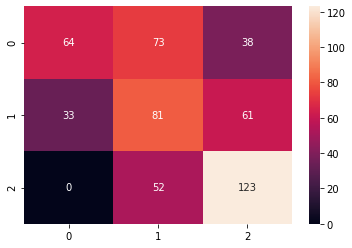

In [41]:
cm = confusion_matrix(y_test_, clf.predict(X_test_))
sns.heatmap(cm, annot=True,fmt='g')
plt.show()

In [42]:
np.save('X_topological.npy', X)

In [43]:
np.save('y.npy', y)

## combine topological and unet

In [36]:
with open('X_topological.npy', 'rb') as f:
    X_topological = np.load(f)
with open('X_unet.npy', 'rb') as f:
    X_unet = np.load(f)

In [42]:
with open('y.npy', 'rb') as f:
    y = np.load(f)

In [37]:
X_unet.shape

(1110, 10)

In [38]:
X_topological.shape

(1110, 10)

In [41]:
X_combined = np.concatenate([X_unet, X_topological] , axis=1)

In [48]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
scores = []
for i in tqdm(range(1000)):
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, shuffle=True)
    rmos = RandomUnderSampler(random_state=2021)
    X_train_, y_train_ = rmos.fit_resample(X_train, y_train)
#     clf = lgb(max_depth=1)
    clf = LogisticRegression(penalty='l1', solver='liblinear')
    clf.fit(X_train_, y_train_)
    rmos = RandomOverSampler(random_state=2021)
    X_test_, y_test_ = rmos.fit_resample(X_test, y_test)
    scores.append(clf.score(X_test_, y_test_))
np.array(scores).mean()

100%|██████████| 1000/1000 [00:04<00:00, 243.67it/s]


0.6377915092877988